# Blood loss simulation

In this simulation, we will see how the physiological variable is affected by a blood loss of 20%
of the total blood volume. The inputs drug rates will remain constant.

In [1]:
import matplotlib.pyplot as plt
import python_anesthesia_simulator as pas

## Definition of the patient simulation

In this cell, a class instance of the simulator is created and initialized at maintenance phase.

Then the rate of the blood loss and fluid replacement are detailled.

In [2]:
ts = 5 # time step in seconds
age, height, weight, gender = 74, 164, 88, 1
George = pas.Patient([age, height, weight, gender], ts=ts,
                           model_propo="Eleveld", model_remi="Eleveld", co_update=True)

tci_propo = pas.TCIController(
    [age, height, weight, gender],
    drug_name="Propofol",
    drug_concentration=10,
    sampling_time=ts,
    model_used="Eleveld",
)
tci_remi = pas.TCIController(
    [age, height, weight, gender],
    drug_name="Remifentanil",
    drug_concentration=10,
    sampling_time=ts,
    model_used="Eleveld",
)
target_remi = 2 # target remifentanil concentration (ng/ml)
target_propo = 4 # target propofol concentration (ug/ml)

# details of the blood loss
start_bleeding_time = 20 # 5 minute
blood_loss = 0.3 # 10% blood loss
blood_loss_time = 1 # 1 minute
blood_rate = George.blood_volume*blood_loss*1000/blood_loss_time # blood loss rate (ml/min)
# details of the fluid replacement
start_transfusion_time = start_bleeding_time + 5 # 10 minutes
transfusion_time = 10 # 10 minutes
transfusion_rate = George.blood_volume*blood_loss*1000/transfusion_time # fluid replacement rate (ml/min)

## Simulation

In [3]:
N_simu = int(60 * 60/ts) # 30 minutes simulation
for index in range(N_simu):
    u_propo = tci_propo.one_step(target_propo)/3600*10
    u_remi = tci_remi.one_step(target_remi)/3600*10
    if index*ts> start_bleeding_time*60 and index*ts<=(start_bleeding_time + blood_loss_time)*60:
        # blood loss
        George.one_step(u_propo=u_propo, u_remi=u_remi,
                        u_nore=0, blood_rate= - blood_rate, noise=False)
    elif index*ts> (start_transfusion_time)*60 and index*ts<=(start_transfusion_time + transfusion_time)*60:
        # fluid replacement
        George.one_step(u_propo=u_propo, u_remi=u_remi,
                        u_nore=0, blood_rate=transfusion_rate, noise=False)
    else:
        # no blood loss or fluid replacement
        George.one_step(u_propo=u_propo, u_remi=u_remi,
                        u_nore=0, noise=False)

## Results

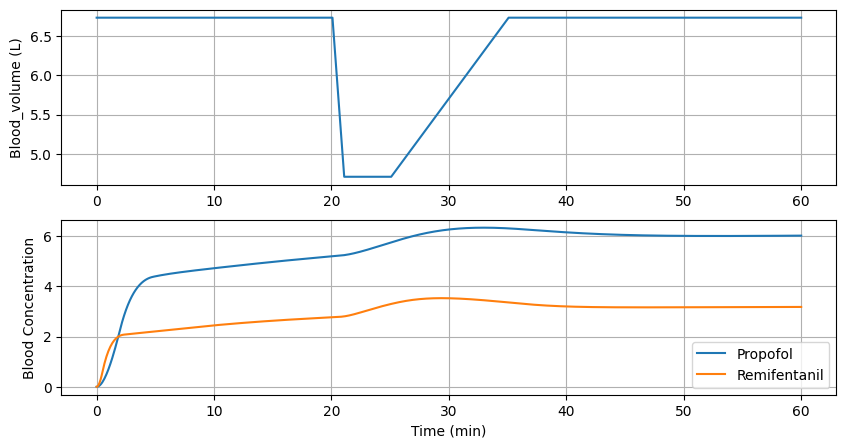

In [4]:
# plot concentration of propofol, remifentanil and norepinephrine
fig, ax = plt.subplots(2, figsize=(10, 5))
Time = George.dataframe['Time']/60
ax[0].plot(Time, George.dataframe['blood_volume'])
ax[0].set_ylabel("Blood_volume (L)")
ax[0].grid()
ax[1].plot(Time, George.dataframe['x_propo_4'], label="Propofol")
ax[1].plot(Time, George.dataframe['x_remi_4'], label="Remifentanil")
# ax[1].plot(Time, George.dataframe['x_nore_1'], label="Norepinephrine")
# ax[1].set_ylim(0, 10)
ax[1].set_ylabel("Blood Concentration")
ax[1].set_xlabel("Time (min)")
plt.legend()
plt.grid()
plt.show()

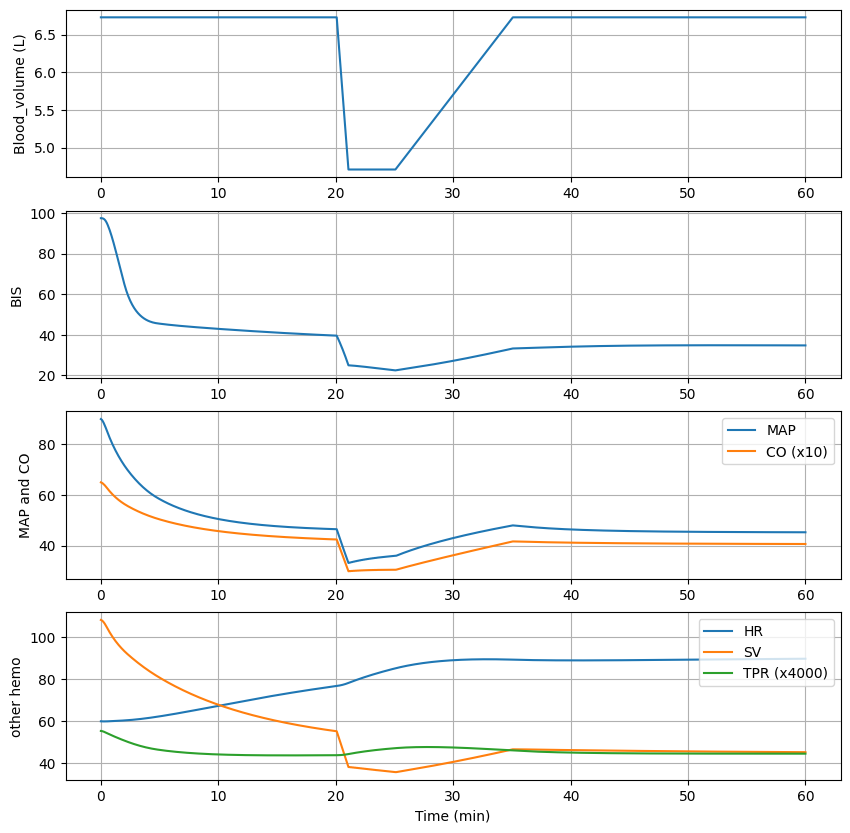

In [5]:
# plot bis, map and co
fig, ax = plt.subplots(4, figsize=(10, 10))
ax[0].plot(Time, George.dataframe['blood_volume'])
ax[0].set_ylabel("Blood_volume (L)")
ax[0].grid()
ax[1].plot(Time, George.dataframe['BIS'])
ax[1].set_ylabel("BIS")
ax[1].grid()
ax[2].plot(Time, George.dataframe['MAP'], label="MAP")
ax[2].plot(Time, George.dataframe['CO']*10, label="CO (x10)")
ax[2].set_ylabel("MAP and CO")
ax[2].grid()
ax[2].legend(loc="upper right")
ax[3].plot(Time, George.dataframe['HR'], label="HR")
ax[3].plot(Time, George.dataframe['SV'], label="SV")
ax[3].plot(Time, George.dataframe['TPR']*4000, label="TPR (x4000)")
ax[3].set_ylabel("other hemo")
ax[3].set_xlabel("Time (min)")
# ax[2].set_xlim([30,50])
# ax[2].set_ylim((30,60))
plt.legend(loc="upper right")
plt.grid()
plt.show()


Here 5 phases can be distinguished:
- Induction phase: the patient is induced with propofol and remifentanil
- Bleeding phase: the patient loses blood
- Maintenance phase: No fluid management but low blood volume
- Transfusion phase: the patient receives blood
- Recovery phase: No fluid management, normal blood volume right after the transfusion

During the bleeding phase, the patient loses blood and the blood volume decreases.
The BIS decrease because the propofol sensitivity of the patient increase.  
MAP and CO decrease as well due to the assumption of direct proportionality between blood volume and stroke volume.

During the maintenance phase, the concentration of all drugs increase because of the low blood volume and the constant drug rate, 
thus BIS decrease. Due to the compensatory mecanisme of the hemodynamic HR and TPR increase which lead to a MAP increasing and a constant CO. 

During the transfusion phase, the blood volume increases. The BIS increase because the propofol sensitivity of the patient decrease.
MAP and CO increase as well due to the assumption of direct proportionality between blood volume and stroke volume.

During the recovery phase, the concentration of all drugs decrease because of the higher blood volume and the constant drug rate.
Thus all the variable return to their initial value.
